<div align="center">
    <a href="https://colab.research.google.com/github/z-a-f/PyTorch-Notebooks/blob/master/00-Primer/PyTorch/Training.ipynb" style="text-align:center">Open in Colab
        <img src="https://colab.research.google.com/img/colab_favicon.ico" width=64/>
    </a>
</div>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

# Learning in PyTorch

In this notebook you will learn how to start with training using the PyTorch framework.

## Data used in this notebook
You will be using a simple synthetic dataset, that will be generated using a simple function shown below.

In [3]:
def create_dataset(poly_args,
                   step_size=0.1,
                   xlim=(0.0, 10.0),
                   xnoise=0.1,
                   ynoise=0.1):
    """Creates a line regression dataset:
    
    y = w0 + w1*x + w2*x^2 +...
    where wi is the ith element in the `poly_args`
    
    Args:
        poly_args: Arguments for the polynomial starting from 0th order
        step_size: Step between consecutive x points
        xlim: minimum and maximum x limit
        xnoise, ynoise: Noise to be added to both x and y
    Returns:
        x, y: tuples with x/y coordinates
        poly_str: String for the polynomial (in LaTeX)
    """
    poly_str = 'y = $'
    x_points = np.arange(xlim[0], xlim[1], step_size)
    num_points = len(x_points)
    x_noise = np.random.randn(num_points) * xnoise
    y_points = poly_args[0]
    
    poly_str += f'-{-poly_args[0]}' if poly_args[0] < 0 else f'{poly_args[0]}'
    
    x = x_points
    for idx, w in enumerate(poly_args[1:], start=1):
        y_points += w * x
        x = x * x_points
        poly_str += f'- {-w}' if w < 0 else f'+ {w}'
        poly_str += f'x^{idx}'
    y_noise = np.random.randn(num_points) * ynoise
    xpoints = np.array(x_points + x_noise, dtype=np.float32).reshape(-1, 1)
    ypoints = np.array(y_points + y_noise, dtype=np.float32).reshape(-1, 1)
    poly_str += '$'
    return torch.from_numpy(xpoints), torch.from_numpy(ypoints), poly_str

Text(0, 0.5, '$y$')

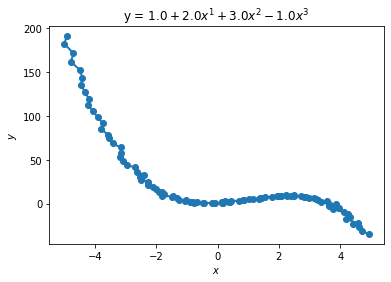

In [4]:
w = [1.0, 2.0, 3.0, -1.0]
x, y, poly_str = create_dataset(poly_args=w,
                                xlim=(-5, 5),
                                step_size=0.1,
                                xnoise=0.1,
                                ynoise=0.5,
                               )

plt.plot(x.cpu(), y.cpu(), '-o', lw=2)
plt.title(poly_str)
plt.xlabel(f'$x$')
plt.ylabel(f'$y$')

## Solving the regression problem using inverses
We can choose any number of parameters for the polynomial.
Any model that we build should predict the y value depending on the x input.
We need to find such a weight matrix $A$ that would 
$$
\begin{align}
XA^T &= \mathbf{y}\\
X^{-1}XA^T &= X^{-1}\mathbf{y}\\
A^T &= X^{-1}\mathbf{y}
\end{align}
$$

where $X$ is the matrix with powers of $\mathbf{x}$:

$$\begin{align}
\begin{pmatrix}
\rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} & \dots & \rule[-1ex]{0.5pt}{2.5ex} \\
1.0 & \mathbf{x} & \mathbf{x}^2 & \dots & \mathbf{x}^{n-1} \\
\rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} & \dots & \rule[-1ex]{0.5pt}{2.5ex} \\
\end{pmatrix}
\end{align}$$

The problem is that $X$ might not be invertible, so it is better to get the pseudo-inverse:

$$
\begin{align}
X^{+} &= (X^TX)^{-1}X^T \\
A &= X^{+}\mathbf{y} \\
&= (X^TX)^{-1}X^T\mathbf{y}
\end{align}
$$

Note that we still don't know how many columns we need to be in $X$, but we can try multiple, and see which one fits better.

### Checkpoint Assignment

In this assignment you need to implement the [pseudo-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) described earlier.
$$
X^{+}= (X^TX)^{-1}X^T\mathbf{y}
$$



In [5]:
def pseudo_inverse(A):
    """Computes the pseudo-inverse of A"""
    # TODO: Write the pseudo-inverse computation
    return torch.randn(A.shape).T

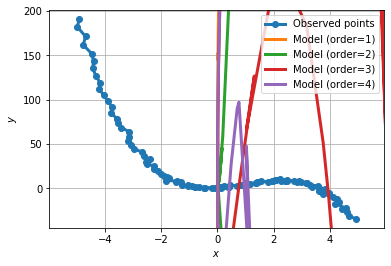

In [6]:
def extend_x(x, n, ones=False):
    """Extends the vector x to the order of n
    (including column of ones)
    
    Args:
        x: vector to be extended to the polynomial
        n: order to be extended to
        ones: include a column of ones
    """
    columns = []
    num_el = len(x)
    x = x.reshape(num_el)
    if ones:
        column = torch.ones(num_el).to(x.device)
    else:
        column = x
    columns.append(column)
    for idx in range(1, n+1):
        column = x * column
        columns.append(column)
    return torch.stack(columns, -1)

x = x.cpu()
y = y.cpu()
plt.plot(x, y, '-o', lw=3, label='Observed points')

for idx in range(1, 5):
    X_extended = extend_x(x, idx)
    X_inverse = pseudo_inverse(X_extended)
    A = X_inverse @ y
    y_hat = X_extended @ A
    
    plt.plot(X_extended[:, 1].cpu(), y_hat.cpu(),
             lw=3, label=f'Model (order={idx})')

plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$y$')
plt.ylim([y.min()-10, y.max()+10])
plt.xlim([x.min()-1, x.max()+1])
plt.grid()

The problem with that method is that it only works for the input datasets to be relatively small.
If the matrices are large (thousands of rows and columns), computing the pseudo-inverse becomes very slow.

PyTorch uses a learning mechanism called [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), which allows the inputs to be of any size, and still maintain good accuracy and performance.

## PyTorch Models

You will learn more about PyTorch models later, but for this exercise let us create a very simple model to predict the regression problem we have.

### How to make PyTorch models

Building a simple sequential model in PyTorch is fairly simple.
You can pass all the layers to `nn.Sequential`. For example, to have a 2d convolution layer followed by a ReLU activation:

```python
model = nn.Sequential(
    nn.Conv2d(num_inputs, num_outputs, kernel_size),
    nn.ReLU()
)
```

Don't worry about what the layers mean, we will cover them later.

The parameters like `kernel_size` are called **hyperparameters**, and are chosen during the design time.
Other hyperparameters are the layers that will be part of the model.

In this exercise let us use a single-layer neurla network:

In [7]:
from torchsummary import summary
input_size = 5

model = nn.Sequential(
    nn.Linear(input_size, 1, bias=False),
)

model = model.to('cuda')

summary(model, (5,), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               5
Total params: 5
Trainable params: 5
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------



(tensor(5), tensor(5))

The model here is just a single neuron that has 5 inputs.
It is equivalent to the matrix multiplication that we used before.

### Choosing Training Parameters

Before you train a network, you need to choose the optimization algorithm as well as the loss function.

#### SGD Optimizer

There are a lot of [optimization algorithms](https://pytorch.org/docs/stable/optim.html) in the PyTorch. 
For this exercise we will use `torch.optim.SGD`, which is a stochastic gradient descent algorithm.
Probably, some other algorithms would converge faster, but for such a small dataset `SGD` should work fine.

#### Loss function

Loss function defines what function describes the error between prediction and the true value.
Different applications work better with different loss fucntions.
Here is a brief list of loss functions and applications.

| Problem Type | Last-Layer | Loss Function |
|:-------------|:---------------------:|:--------------|
| Binary Classifiction | `nn.Sigmoid`  | `nn.CrossEntropyLoss` |
| Multiclass, single-label Classification | `nn.Softmax` | `nn.CrossEntropyLoss` |
| Multiclass, multi-label Classification | `nn.Sigmoid` | `nn.CrossEntropyLoss` |
| Regression (arbitrary) | None<br>`nn.Linear` | `nn.MSELoss` |
| Regression (binary) | `nn.Sigmoid` | `nn.MSELoss`<br>`nnCrossEntropyLoss` |

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()

**CUDA**

At this stage if a GPU is available, it is time to send the data and the model to CUDA.

In [9]:
# Send the data to the GPU (if available)
device = 'cuda' if torch.cuda.is_available else 'cpu'

model = model.to(device)
x = x.to(device)
y = y.to(device)

X_extended = extend_x(x, input_size-1, ones=True)  # Bias is already included

## Training

The training step follows the routine:

1. While number of epochs is small
    1. Split the data into batches
    1. For every batch
        1. Evaluate the model
        1. Compute the error (loss)
        1. Backpropagate the error
        1. Update the trainable parameters
    1. Increment epochs
    
Below is the training for the regression problem that we have.

In [10]:
EPOCHS = 5000
batch_size = 128

print_every = 500

for epoch in range(EPOCHS):
    start = 0
    running_loss = 0
    while start < len(x):
        end = start + batch_size
        # Get the batch of data
        x_batch = X_extended[start:end]
        y_batch = y[start:end]
        start = end
        # Reset the optimizer
        optimizer.zero_grad()
        # Compute the result
        y_hat = model(x_batch)
        # Get the loss and propagate it back
        loss = loss_fn(y_hat, y_batch)
        loss.backward()
        # Update the trainable parameters
        optimizer.step()
        # Log the Loss
        running_loss += loss.item()
    if (epoch+1) % print_every == 0:
        print(f'{epoch+1} / {EPOCHS} Loss: {running_loss / len(x)}')

500 / 5000 Loss: 1.0576326751708984
1000 / 5000 Loss: 0.8830071258544921
1500 / 5000 Loss: 0.7409947204589844
2000 / 5000 Loss: 0.6254769897460938
2500 / 5000 Loss: 0.5314832305908204
3000 / 5000 Loss: 0.4549769592285156
3500 / 5000 Loss: 0.39267841339111326
4000 / 5000 Loss: 0.3419240570068359
4500 / 5000 Loss: 0.30055036544799807
5000 / 5000 Loss: 0.26680009841918945


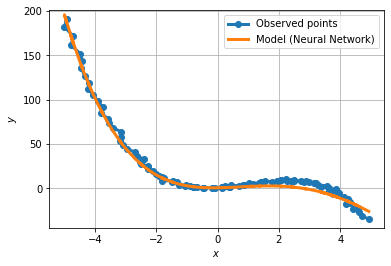

In [11]:
plt.plot(x.cpu(), y.cpu(), '-o', lw=3, label='Observed points')
model = model.eval().cuda()
y_hat = model(X_extended)

plt.plot(X_extended[:, 1].cpu(), y_hat.detach().cpu(),
         lw=3, label=f'Model (Neural Network)')

plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$y$')
plt.ylim([y.min().item()-10, y.max().item()+10])
plt.grid()

### Checkpoint Assignment

Create a new model with two `nn.Linear` layers. with an activation between them.
Here is the list of the activation functions that you can try: `nn.ReLU`, `nn.Sigmoid`, and `nn.Tanh`.
Also change the optimizer to `optim.Adagrad`.

**Note:** You will need to change the learning rate to make the new optimizer work. Try `1e-2`, `1e-1`, and `1.0`, and see which one works better.

Here is how your model could like, depending on the activation you use and intermediate size you have:

```
-------------------------------------------------------------
        Layer (type)            Output Shape         Param #
=============================================================
            Linear-1                 [-1, 3]              18
              ReLU-2                 [-1, 3]               0
            Linear-3                 [-1, 1]               4
==============================================================
```

In [17]:
import warnings
from torch import optim

model = nn.Sequential(
    # TODO: Add the componenst here
    nn.Identity()  # This is a placeholder
)

summary(model, (5,), device='cpu')

try:
    optimizer = optim.SGD(model.parameters(), lr=1e-6)  # This is a placeholder
except ValueError:
    warnings.warn("The model has not parameters! Did you add Linear?")
loss_function = nn.MSELoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Identity-1                    [-1, 5]               0
Total params: 0
Trainable params: 0
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------



/home/zafar/miniconda3/envs/py37-ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: The model has not parameters! Did you add Linear?
  


In [ ]:
EPOCHS = 5000
batch_size = 128

print_every = 500

for epoch in range(EPOCHS):
    start = 0
    running_loss = 0
    while start < len(x):
        end = start + batch_size
        # Get the batch of data
        x_batch = X_extended[start:end]
        y_batch = y[start:end]
        start = end
        # Reset the optimizer
        optimizer.zero_grad()
        # Compute the result
        y_hat = model(x_batch)
        # Get the loss and propagate it back
        loss = loss_fn(y_hat, y_batch)
        loss.backward()
        # Update the trainable parameters
        optimizer.step()
        # Log the Loss
        running_loss += loss.item()
    if (epoch+1) % print_every == 0:
        print(f'{epoch+1} / {EPOCHS} Loss: {running_loss / len(x)}')

In [ ]:
plt.plot(x.cpu(), y.cpu(), '-o', lw=3, label='Observed points')
model = model.eval().cuda()
y_hat = model(X_extended)

plt.plot(X_extended[:, 1].cpu(), y_hat.detach().cpu(),
         lw=3, label=f'Model (Neural Network)')

plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$y$')
plt.ylim([y.min().item()-10, y.max().item()+10])
plt.grid()

## Conclusion

Now you know how to create a very basic model and to train it.
In the later sections I will show you how to validate and test your models.

*Note on the losses:* It is often useful to combine the losses or to create a custom ones. However, PyTorch framwork has a wide range of different loss functions you can start with.